# House Price Prediction

This dataset contains house sale prices in King County, which includes Seattle. It includes 21613 homes sold between May 2014 and May 2015.


The main purpose of this analysis is to analyze the data and to develop a predictive model that will allow to predict future prices in King County.

The description for the 21 features is given below:


id :a notation for a house

date: Date house was sold

price: Price is prediction target

bedrooms: Number of Bedrooms

bathrooms: Number of bathrooms

sqft_living: square footage of the home

sqft_lot: square footage of the lot

floors :Total floors (levels) in house

waterfront :House which has a view to a waterfront

view: Has been viewed

condition :How good the condition is Overall

grade: overall grade given to the housing unit, based on King County grading system

sqft_above :square footage of house apart from basement

sqft_basement: square footage of the basement

yr_built :Built Year

yr_renovated :Year when house was renovated

zipcode:zip code

lat: Latitude coordinate

long: Longitude coordinate

sqft_living15 :Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area

sqft_lot15 :lotSize area in 2015(implies-- some renovations)

# Import libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy import stats
from scipy.special import boxcox1p
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as csx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso, ElasticNet, Ridge, HuberRegressor
from sklearn.linear_model import BayesianRidge, LogisticRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

# Load data

In [88]:
df = pd.read_csv('kc_house_data.csv',parse_dates=['date'])

In [89]:
df.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Display information about the data

In [90]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null datetime64[ns]
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(15)
memory usage: 3.5 MB


Firstly, basic information about memory usage and data types are checked. Except date feature, all others variables are numerical. Moreover doesn't contain null values.

# Display some statistics about the data

In [91]:
describe=df.describe()
describe.apply(lambda x: round(x,1))

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0
mean,4.580302e+09,540088.1,3.4,2.1,2079.9,15107.0,1.5,0.0,0.2,3.4,7.7,1788.4,291.5,1971.0,84.4,98077.9,47.6,-122.2,1986.6,12768.5
std,2.876566e+09,367127.2,0.9,0.8,918.4,41420.5,0.5,0.1,0.8,0.7,1.2,828.1,442.6,29.4,401.7,53.5,0.1,0.1,685.4,27304.2
min,1.000102e+06,75000.0,0.0,0.0,290.0,520.0,1.0,0.0,0.0,1.0,1.0,290.0,0.0,1900.0,0.0,98001.0,47.2,-122.5,399.0,651.0
25%,2.123049e+09,321950.0,3.0,1.8,1427.0,5040.0,1.0,0.0,0.0,3.0,7.0,1190.0,0.0,1951.0,0.0,98033.0,47.5,-122.3,1490.0,5100.0
50%,3.904930e+09,450000.0,3.0,2.2,1910.0,7618.0,1.5,0.0,0.0,3.0,7.0,1560.0,0.0,1975.0,0.0,98065.0,47.6,-122.2,1840.0,7620.0
75%,7.308900e+09,645000.0,4.0,2.5,2550.0,10688.0,2.0,0.0,0.0,4.0,8.0,2210.0,560.0,1997.0,0.0,98118.0,47.7,-122.1,2360.0,10083.0
max,9.900000e+09,7700000.0,33.0,8.0,13540.0,1651359.0,3.5,1.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2015.0,98199.0,47.8,-121.3,6210.0,871200.0


<b>Key insights:</b>

-the average price of house is equal USD 540088<br>
-the average square footage of the home is 15107<br>
-the average condition of house is equal 3.4, where 5 is maximum<br>
-the average year the house was built is 1971<br>
-on average, the house has two bathrooms and three bedrooms



# Deeper look at target variable

In [92]:
df.drop(['zipcode','id'],axis=1).corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
Name: price, dtype: float64

The most corelated features to target variable (price) are: sqft_living, grade, sqft_above, sqft_living15, bathrooms.

In [93]:
df.price.describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

# Display distributions of the price 


 mu = 540088.14 and sigma = 367118.70



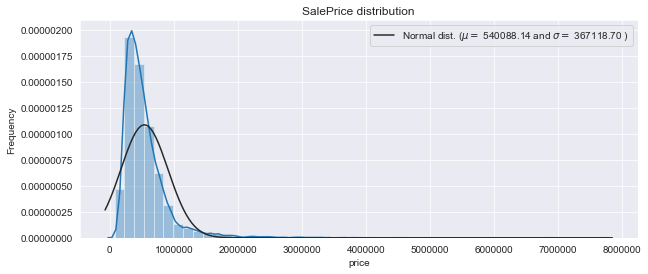

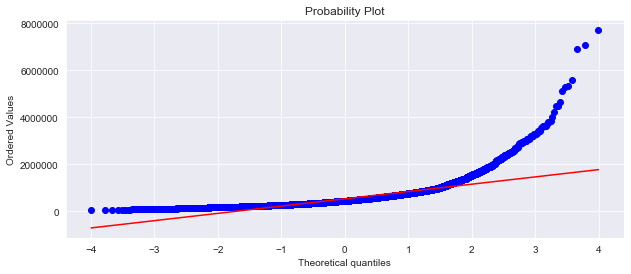

In [94]:

plt.figure(figsize=(10,4))
color = sns.color_palette()
sns.set_style('darkgrid')
sns.distplot(df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(10,4))
res = stats.probplot(df['price'], plot=plt)
plt.show()

The distribution of the price is right-skewed. Skewness may violate linear model assumptions, so let's try to normalize it, by using log(1+x) transformation.


 mu = 13.05 and sigma = 0.53



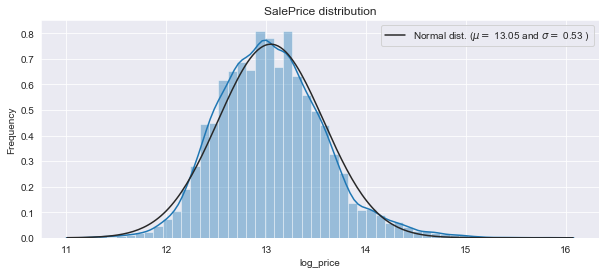

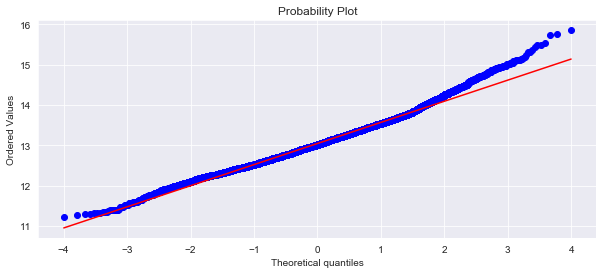

In [95]:
plt.figure(figsize=(10,4))
df["log_price"] = np.log1p(df["price"])
sns.distplot(df['log_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['log_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(10,4))
res = stats.probplot(df['log_price'], plot=plt)
plt.show()

In [96]:
jarque_bera_test = stats.jarque_bera(df.log_price)
print('statistic={:.2f}, pvalue={:.2f}'.format(jarque_bera_test[0],jarque_bera_test[1]))

statistic=1090.52, pvalue=0.00


In [97]:
k2, p = stats.normaltest(df.log_price)
print('statistic={:.2f}, pvalue={}'.format(k2,p))

statistic=852.19, pvalue=8.879246628768088e-186


In [98]:
skew(df.price)

4.023789858140135

After transformation the distribution seems to be normal. Unfortunately statistics tests rejected the null hypothesis that a sample comes from a normal distribution.

In [99]:
df.nunique()

id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
log_price         4028
dtype: int64

The number of unique values for each feature is indicated above. For many of them, the number is relatively low, which suggests some variables can be considered as 'category' type.

# Data exploration

count    21613.000000
mean      2079.899736
std        918.440897
min        290.000000
25%       1427.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

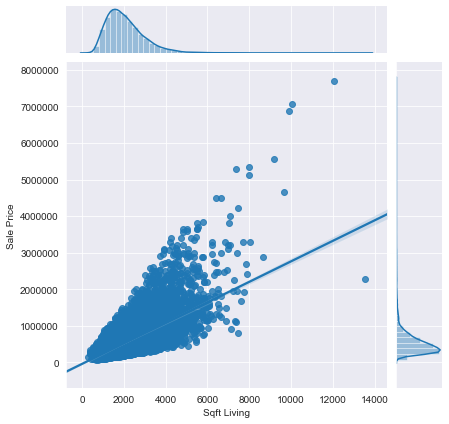

In [100]:

g = sns.JointGrid(x="sqft_living", y="price", data=df, ratio=6)
g = g.plot(sns.regplot, sns.distplot)
plt.xlabel('Sqft Living')
plt.ylabel('Sale Price')
df.sqft_living.describe()

The chart above shows that most of the properties have square footage of the home between 300 and 6000 square feet. On the chart we can also see that one of the properties, which the biggest square footage has realtively low price. It seems to be outlier. We will remove it.

In [101]:
df.drop(df[df.sqft_living>13500].index, axis=0, inplace=True)

In [102]:
def display_count(plot):
    for p in plot.patches:
        plot.annotate(s = round(p.get_height(),0), 
                      xy = (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 8), 
                      textcoords = 'offset points',
                      color='black',
                      fontsize=12)

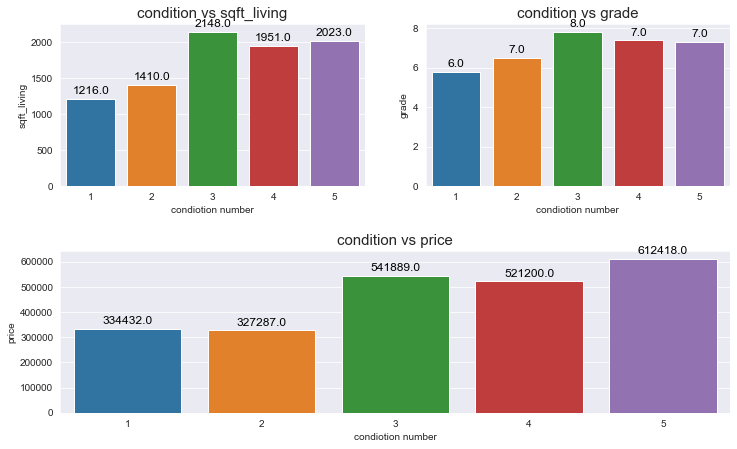

In [103]:
plt.figure(figsize = (12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

ax1 = plt.subplot(212)
ax1 = sns.barplot(x="condition", y='price', 
                    data=df, ax=ax1, ci=None)
ax1.set_title("condition vs price", fontsize=15)
ax1.set_xlabel("condiotion number")
ax1.set_ylabel("price")
display_count(ax1)

ax2 = plt.subplot(222)
ax2 = sns.barplot(x="condition", y='grade', 
                    data=df, ax=ax2, ci=None)
ax2.set_title("condition vs grade", fontsize=15)
ax2.set_xlabel("condiotion number")
ax2.set_ylabel("grade")
display_count(ax2)

ax0 = plt.subplot(221)
ax0 = sns.barplot(x="condition", y='sqft_living', 
                    data=df, ax=ax0 ,ci=None)
ax0.set_title("condition vs sqft_living", fontsize=15)
ax0.set_xlabel("condiotion number")
ax0.set_ylabel("sqft_living")
display_count(ax0)

Let's look at the influence of the condition on the price of a house. As can be seen in the charts above better condition standards not always translate into higher price. This is because houses with a condition of 3 are usually larger and receive better grades, which translates more into price than condition.

In [104]:
df[(df.bedrooms==0)&(df.bathrooms==0)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
875,6306400140,2014-06-12,1095000.0,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000,13.906266
3119,3918400017,2015-02-05,380000.0,0,0.0,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399,12.847929
6994,2954400190,2014-06-24,1295650.0,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061,14.074524
9773,3374500520,2015-04-29,355000.0,0,0.0,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050,12.779876
9854,7849202190,2014-12-23,235000.0,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200,12.367345
14423,9543000205,2015-04-13,139950.0,0,0.0,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600,11.849048
19452,3980300371,2014-09-26,142000.0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850,11.863589


What causes additional doubts are situations where some of the houses have no bedrooms and bathrooms. This situation cannot of course occur. We will drop these rows. 

In [105]:
df.drop(df[(df.bedrooms==0)&(df.bathrooms==0)].index,axis=0, inplace=True)

<Figure size 864x576 with 0 Axes>

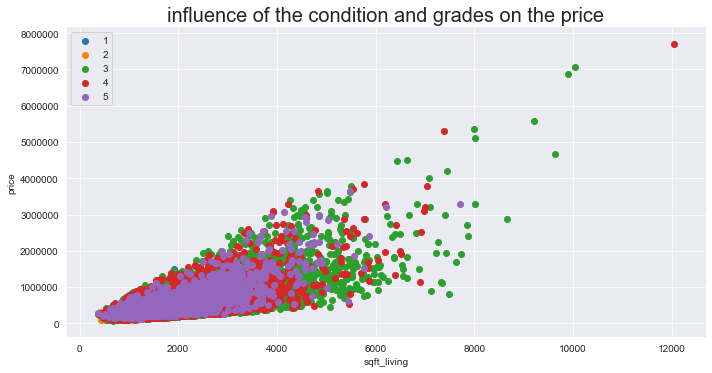

In [106]:
plt.figure(figsize = (12,8))
g = sns.FacetGrid(data=df, hue='condition',size= 5, aspect=2)
g.map(plt.scatter, "sqft_living", "price")
plt.title('influence of the condition and grades on the price',fontsize=20)
plt.legend()
plt.show()

2.0    13851
1.0     3933
3.0     2527
4.0     1201
5.0       57
6.0       24
0.0        7
8.0        3
7.0        2
Name: bathrooms, dtype: int64

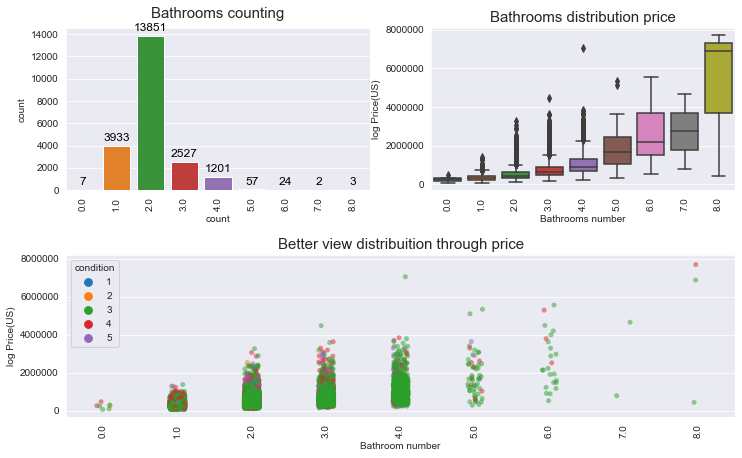

In [107]:
plt.figure(figsize = (12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)
df.bathrooms = df.bathrooms.apply(lambda x: round(x,0))
ax1 = plt.subplot(221)
ax1 = sns.countplot(x="bathrooms", data=df,
                    ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("Bathrooms counting", fontsize=15, pad=10)
ax1.set_xlabel("Bathrooms number")
ax1.set_xlabel("count")
display_count(ax1)

ax2 = plt.subplot(222)
ax2 = sns.boxplot(x="bathrooms", y='price',
                  data=df, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title("Bathrooms distribution price", fontsize=15)
ax2.set_xlabel("Bathrooms number")
ax2.set_ylabel("log Price(US)")

ax0 = plt.subplot(212)
ax0 = sns.stripplot(x="bathrooms", y="price",
                    data=df, alpha=0.5,
                    jitter=True, hue="condition")
ax0.set_title("Better view distribuition through price", fontsize=15)
ax0.set_xlabel("Bathroom number")
ax0.set_ylabel("log Price(US)")
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=90)
df.bathrooms.value_counts()

<b>Key insight</b>

-the most common are two bathrooms in the house<br>
-the greater the number of bathrooms, the higher the price<br>

Text(0.5, 0.98, 'Condition Effect to Sale Price')

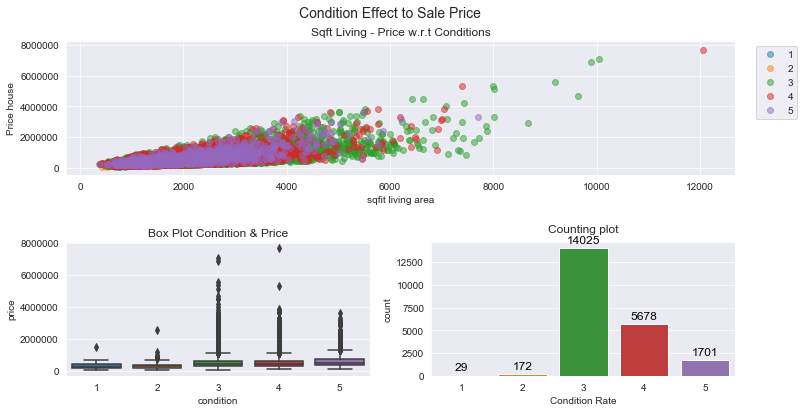

In [108]:
plt.figure(figsize = (12,6))
ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)

for val in range(1,6,1):
    indeX = df.condition == val
    ax1.scatter(df.sqft_living.loc[indeX], df.price.loc[indeX], label = val, alpha=0.5)
ax1.legend(bbox_to_anchor = [1.1, 1])
ax1.set_xlabel('sqfit living area')
ax1.set_ylabel('Price house')
ax1.set_title('Sqft Living - Price w.r.t Conditions')

ax2 = plt.subplot2grid((2,2), (1,0))
sns.boxplot(x = 'condition', y = 'price', data = df, ax = ax2)
ax2.set_title('Box Plot Condition & Price', fontsize = 12)

ax3 = plt.subplot2grid((2,2), (1,1))
sns.countplot(x="condition", data=df,
                    ax=ax3)
ax3.set_title('Counting plot', fontsize = 12, pad=10)
ax3.set_xlabel('Condition Rate')
display_count(ax3)
plt.subplots_adjust(hspace = 0.5, top = 0.9)
plt.suptitle('Condition Effect to Sale Price', fontsize = 14)

<b>Key insight</b>

-the most common condition rate is 3 <br>
-the highest prices received house with conditions rate equal to 3 and 4, but it also depends on square footage<br>

Text(0.5, 0.98, '"VIEW" Effect To SalePrice')

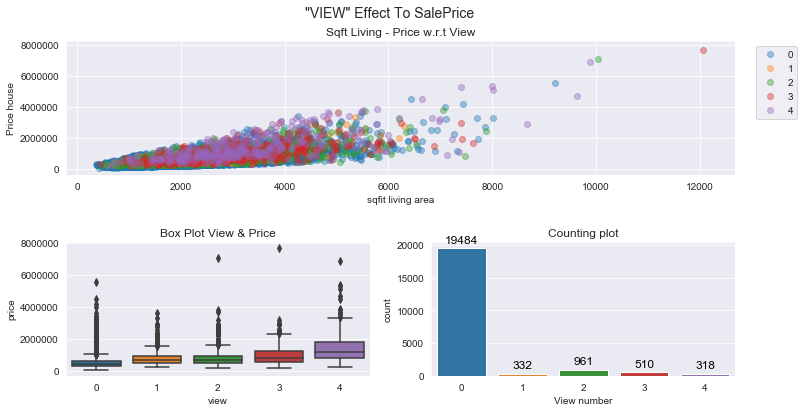

In [109]:
plt.figure(figsize = (12,6))
ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)

for val in range(0,5,1):
    indeX = df.view == val
    ax1.scatter(df.sqft_living.loc[indeX], df.price.loc[indeX], label = val, alpha=0.4)
ax1.legend(bbox_to_anchor = [1.1, 1])
ax1.set_xlabel('sqfit living area')
ax1.set_ylabel('Price house')
ax1.set_title('Sqft Living - Price w.r.t View')

ax2 = plt.subplot2grid((2,2), (1,0))
sns.boxplot(x = 'view', y = 'price', data = df, ax = ax2)
ax2.set_title('Box Plot View & Price', fontsize = 12)

ax3 = plt.subplot2grid((2,2), (1,1))
sns.countplot(x="view", data=df,
                    ax=ax3)
ax3.set_title('Counting plot', fontsize = 12)
ax3.set_xlabel('View number')
display_count(ax3)
plt.subplots_adjust(hspace = 0.5, top = 0.9)
plt.suptitle('"VIEW" Effect To SalePrice', fontsize = 14)

<b>Key insight</b>

-there is no significant impact between how many times the house had been viewed by potencial buyer and price <br>
-mostly the house has not been viewed at all <br>

Text(0, 0.5, 'Price')

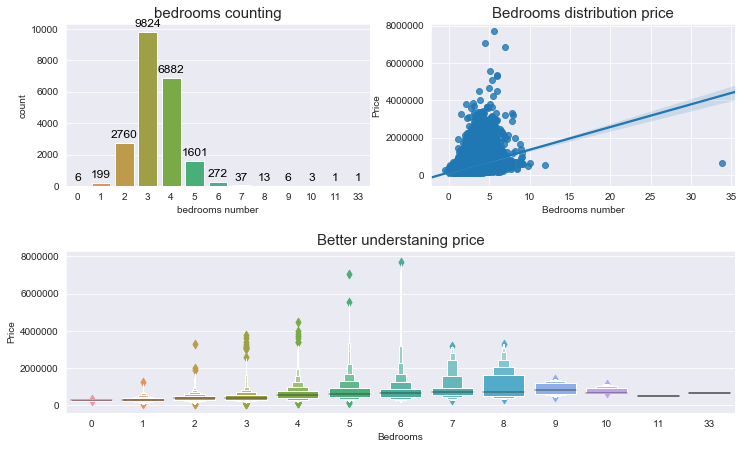

In [110]:
plt.figure(figsize = (12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)


ax1 = plt.subplot(221)
ax1 = sns.countplot(x="bedrooms", data=df,
                    ax=ax1)
ax1.set_title("bedrooms counting", fontsize=15)
ax1.set_xlabel("bedrooms number")
ax1.set_ylabel("count")
display_count(ax1)

ax2 = plt.subplot(222)
ax2 = sns.regplot(x="bedrooms", y='price', 
                  data=df, ax=ax2, x_jitter=True)
ax2.set_title("Bedrooms distribution price", fontsize=15)
ax2.set_xlabel("Bedrooms number")
ax2.set_ylabel("Price")

ax0 = plt.subplot(212)
ax0 = sns.lvplot(x="bedrooms", y="price",
                    data=df)
ax0.set_title("Better understaning price", fontsize=15)
ax0.set_xlabel("Bedrooms")
ax0.set_ylabel("Price")


<b>Key insight</b>

-the most common are three or four bedrooms in the house<br>
-the highest prices received houses with 5 or 6 bedrooms, but there is no significant relation between number of bedrooms and price of the house<br>

*On the distribution chart we can also see that one of the houses has realy big number of bedrooms and realtively low price. It seems to be outlier. We will remove it.

In [111]:
df.drop(df[df.bedrooms==33].index, axis=0, inplace=True)

Text(0, 0.5, 'Price')

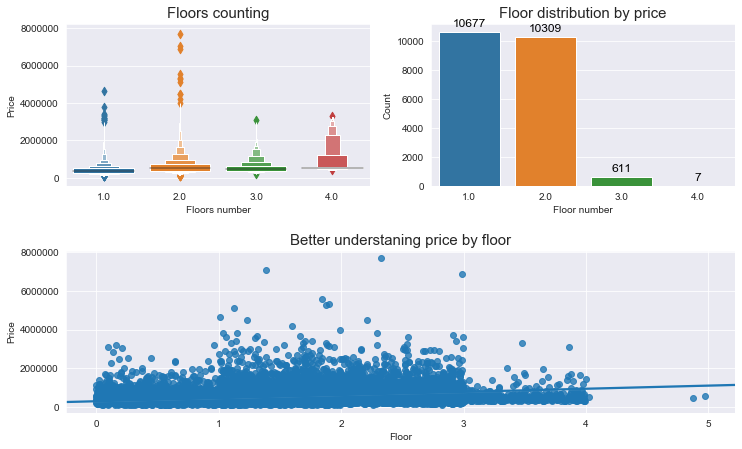

In [112]:
plt.figure(figsize = (12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)
df.floors = df.floors.apply(lambda x: round(x,0))
ax1 = plt.subplot(221)
ax1 = sns.lvplot(x="floors", y='price', 
                    data=df, ax=ax1, )
ax1.set_title("Floors counting", fontsize=15)
ax1.set_xlabel("Floors number")
ax1.set_ylabel("Price")

ax2 = plt.subplot(222)
ax2 = sns.countplot(x="floors",
                  data=df, ax=ax2)
ax2.set_title("Floor distribution by price", fontsize=15)
ax2.set_xlabel("Floor number")
ax2.set_ylabel("Count")
display_count(ax2)

ax0 = plt.subplot(212)
ax0 = sns.regplot(x="floors", y="price", #I need to change floors by sqft_living and hue bye floors
                    data=df, x_jitter=True)
ax0.set_title("Better understaning price by floor", fontsize=15)
ax0.set_xlabel("Floor")
ax0.set_ylabel("Price")

<b>Key insight</b>

-the most common are houses with one or two floors <br>
-the highest prices received houses with 2 floors, but there are no significant relation between number of floors and price of the house <br>

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

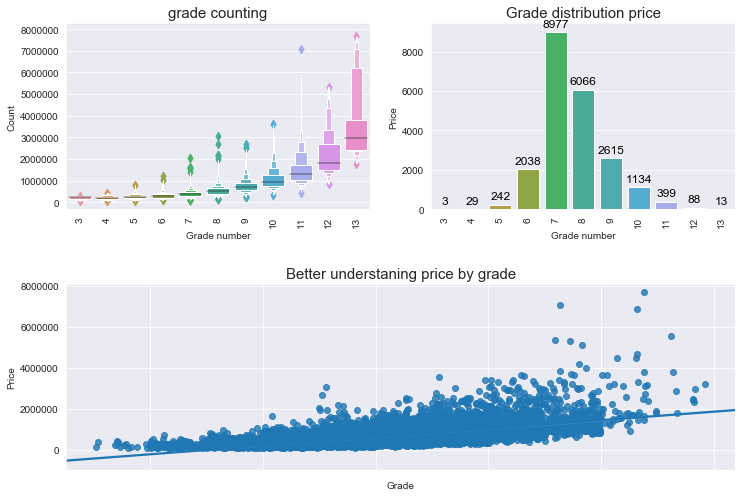

In [113]:
plt.figure(figsize = (12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.9)

ax1 = plt.subplot(221)
ax1 = sns.lvplot(x="grade", y='price', 
                    data=df, ax=ax1, )
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("grade counting", fontsize=15)
ax1.set_xlabel("Grade number")
ax1.set_ylabel("Count")

ax2 = plt.subplot(222)
ax2 = sns.countplot(x="grade",
                  data=df, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title("Grade distribution price", fontsize=15)
ax2.set_xlabel("Grade number")
ax2.set_ylabel("Price")
display_count(ax2)

ax0 = plt.subplot(212)
ax0 = sns.regplot(x="grade", y="price",
                    data=df, x_jitter=True)
ax0.set_title("Better understaning price by grade", fontsize=15)
ax0.set_xlabel("Grade")
ax0.set_ylabel("Price")
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=90)


<b>Key insight</b>

-the most common grades based on king county grading system are 7 and 8<br>
-the greater grades, the higher the price<br>

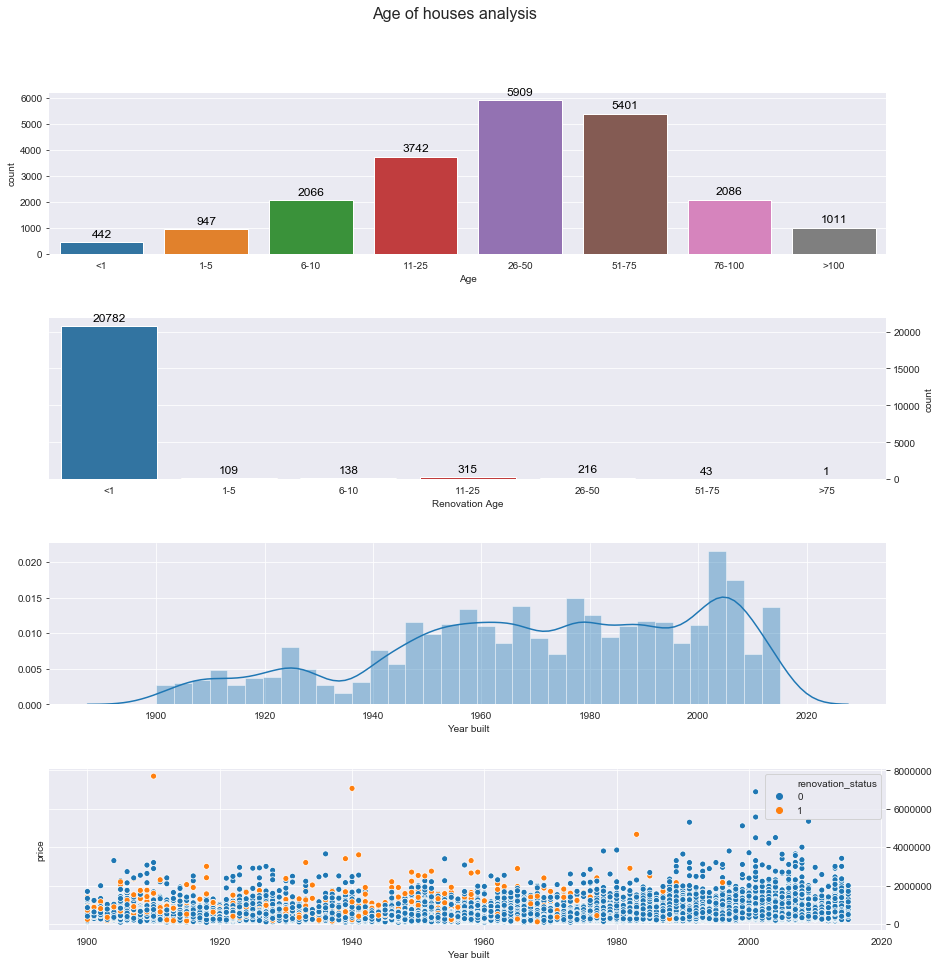

In [114]:
df2=df.copy()
df2['date_sold']=df2['date'].dt.year
df2['age_building'] = df2['date_sold'].astype(int)-df2['yr_built']
df2['age_renovation']=df2['date_sold'][df2['yr_renovated']!=0].astype(int)-df2['yr_renovated'][df2['yr_renovated']!=0]
df2['age_renovation'][df2['age_renovation'].isnull()]=0
bins = [-2,0,5,10,25,50,75,100,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']
df2['age_binned'] = pd.cut(df2['age_building'], bins=bins, labels=labels)
# partition the age_rnv into bins
bins = [-2,0,5,10,25,50,75,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','>75']
df2['age_rnv_binned'] = pd.cut(df2['age_renovation'], bins=bins, labels=labels)
df2['renovation_status']=df2['yr_renovated'].apply(lambda x: 1 if x!=0 else 0)
# histograms for the binned columns
f, axes = plt.subplots(4,1,figsize=(15,15))
plt.subplots_adjust(hspace = 0.4, top = 0.9)
ax1=sns.countplot(df2['age_binned'],ax=axes[0])
display_count(ax1)
ax2=sns.countplot(df2['age_rnv_binned'],ax=axes[1])
sns.despine(left=True, bottom=True)
display_count(ax2)
sns.distplot(df2['yr_built'],ax=axes[2])
sns.scatterplot(x='yr_built',y='price' ,data=df2,ax=axes[3],hue='renovation_status',color='navy')
axes[0].set(xlabel='Age')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Renovation Age');
axes[2].set(xlabel='Year built')
axes[2].yaxis.tick_left()
axes[3].yaxis.tick_right()
axes[3].set(xlabel='Year built');
f.suptitle('Age of houses analysis', fontsize=16);


<b>Key insight</b>

-most often houses are between 26 and 50 years old<br>
-year of built of the house has no significant impact on price of the house<br>
-after 2000 there is an increase in the construction of new houses

In [29]:
df1 = df.sample(3000)
geometry = [Point(xy) for xy in zip(df1.long, df1.lat)]
geo_df = gpd.GeoDataFrame(df1, crs = {'init':'epsg:4326'}, geometry=geometry)

(-13644229.614025343,
 -13499247.104061726,
 5962439.313192923,
 6075053.666729601)

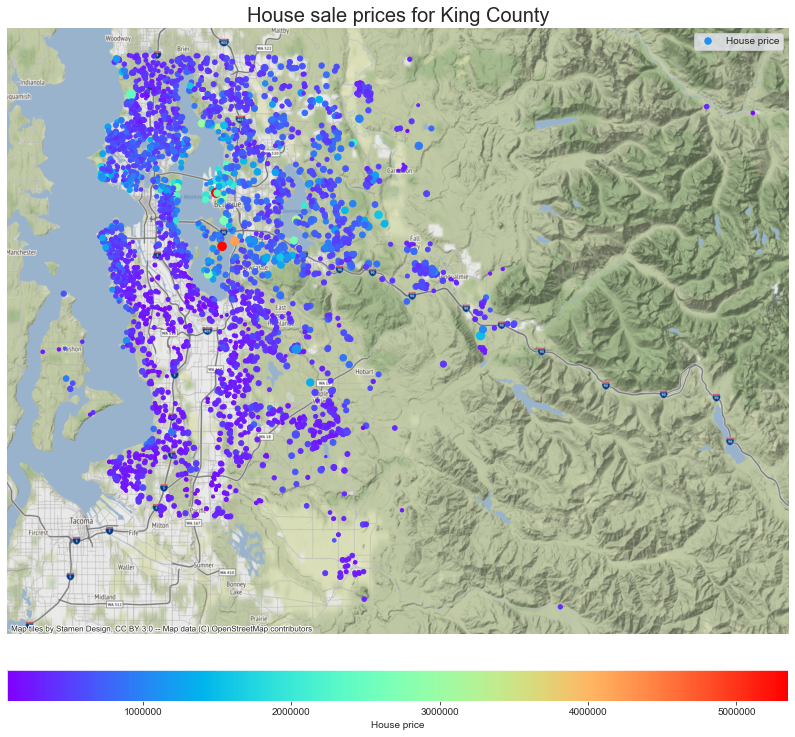

In [30]:
geo_df = geo_df.to_crs(epsg=3857)

fig, ax =plt.subplots(figsize=(14,17))
divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.5)
geo_df.plot(ax=ax, markersize=geo_df.sqft_living/100, column='price',marker='o', cmap='rainbow',alpha=1,label='House price',legend=True,
            legend_kwds={'label': "House price",'orientation': "horizontal"},cax=cax)
csx.add_basemap(ax)
ax.set_title('House sale prices for King County',fontsize=20)
ax.legend()
ax.axis('off')

Locations of random 2000 real estates are presented into map above. The color of the marker represents the price of the property. The size represents its square footage of house.

It can be seen that the properties are concentrated closer to the city center and near lakes. What is also visible is a significant increase in price the closer to the lakes.

# Preprocessing data

In [115]:
print(df['yr_renovated'].value_counts(normalize=True))
print('###############################################')
print(df['sqft_basement'].value_counts(normalize=True))

0       0.957693
2014    0.004212
2013    0.001713
2003    0.001666
2000    0.001620
          ...   
1934    0.000046
1959    0.000046
1951    0.000046
1948    0.000046
1944    0.000046
Name: yr_renovated, Length: 70, dtype: float64
###############################################
0       0.607249
600     0.010230
700     0.010091
500     0.009906
800     0.009535
          ...   
2500    0.000046
2580    0.000046
1525    0.000046
1770    0.000046
1135    0.000046
Name: sqft_basement, Length: 305, dtype: float64


In [116]:
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x != 0 else 0)
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 1 if x != 0 else 0)

The predictor variable ‘renovated’ contained mostly zero fields which indicated that the property was not renovated. This variable has changed to a binary ‘yes’ and ‘no’ field.Likewise, sqft_basement has changed to Basement ‘yes’,‘no’.

# Display correlation matrix to check multicollinearity

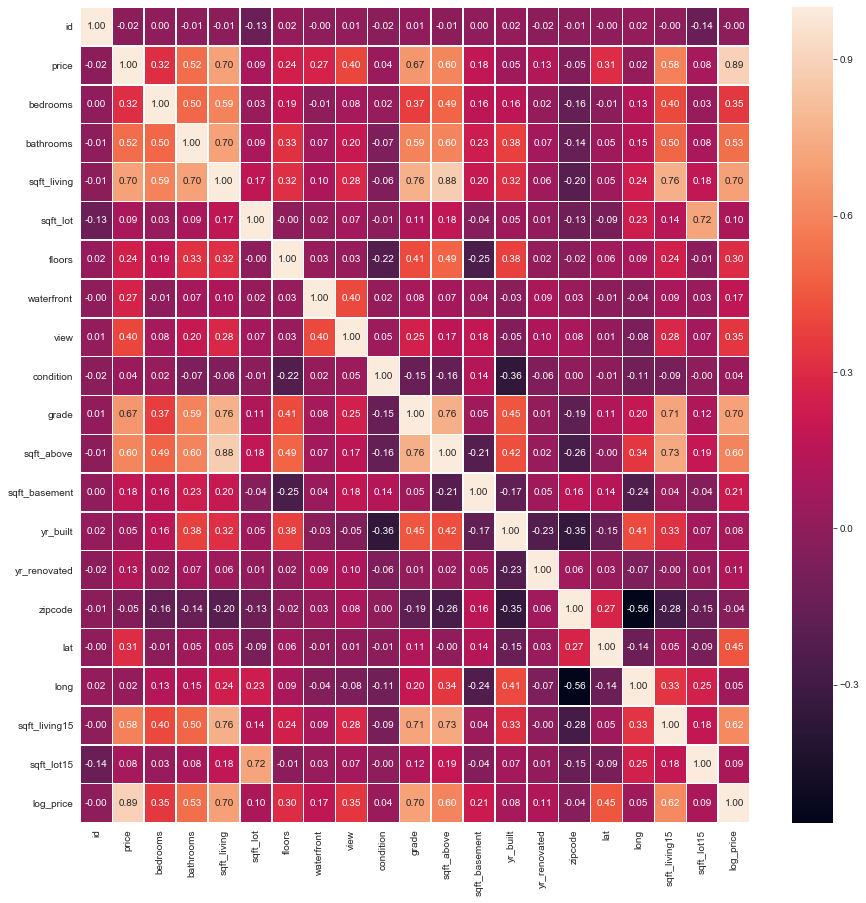

In [117]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(),annot=True, fmt=".2f", linewidths=.5, ax=ax)
plt.show()

Multicollinearity exists whenever an independent variable is highly correlated with one or more of the other independent variables in a multiple regression equation. Multicollinearity is a problem because it undermines the statistical significance of an independent variable. When the model tries to estimate their unique effects, it goes wonky.

The correlation matrix shows that some independent variables are highly correlated with each other. Let's use the variance inflation factor (VIF) to identifies correlation between independent variables and the strength of that correlation.

In [118]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at VIF index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [119]:
calculate_vif_(df.drop(['price','date','id','zipcode','lat','long','log_price'],axis=1))

dropping 'grade' at VIF index: 8
dropping 'sqft_living' at VIF index: 2
dropping 'yr_built' at VIF index: 9
dropping 'sqft_above' at VIF index: 7
dropping 'bedrooms' at VIF index: 0
dropping 'bathrooms' at VIF index: 0
dropping 'sqft_living15' at VIF index: 7
dropping 'condition' at VIF index: 4
Remaining variables:
Index(['sqft_lot', 'floors', 'waterfront', 'view', 'sqft_basement',
       'yr_renovated', 'sqft_lot15'],
      dtype='object')


,sqft_lot,floors,waterfront,view,sqft_basement,yr_renovated,sqft_lot15
0,5650,1.0,0,0,0,0,5650
1,7242,2.0,0,0,1,1,7639
2,10000,1.0,0,0,0,0,8062
3,5000,1.0,0,0,1,0,5000
4,8080,1.0,0,0,0,0,7503
...,...,...,...,...,...,...,...
21608,1131,3.0,0,0,0,0,1509
21609,5813,2.0,0,0,0,0,7200
21610,1350,2.0,0,0,0,0,2007
21611,2388,2.0,0,0,0,0,1287


After removing multicollinearity the dataset contains only 7 columns. It looks we also reduce features which will eventually result in a less complex model and can leads to worse performance of model. In futher analysis let's compare models with multicollinearity and without multicollinearity.

# Modelling

In the last part of the analysis, regression and prediction of real estate prices will be carried out. Due to the fact of exsist multicollinearity within a dataset , the prediction will be divided into two separate models. 

In [120]:
df=df.sample(10000)
df.drop(['id', 'date','long','lat','zipcode','price'], axis=1, inplace=True)
df2=df[['sqft_lot', 'waterfront', 'view', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'sqft_lot15','log_price']]
df1=df.copy()

Below is the automatic evaluation of selected models based on their predictive abilities for different data sets.

All models will be evaluated based on root mean square error (RMSE)

In [121]:
#defining lists for comparing models with loops
scores_df = pd.DataFrame()
datasets = [df2, df1]
set_names = ['df_without_multicollinearity','df_with_multicollinearity']
models = [
     #standard models
    BayesianRidge(),
    Lasso(), 
    Ridge(), 
    ElasticNet(), 
    DecisionTreeRegressor(),
    SVR(), 
    KNeighborsRegressor(),
    #ensemble models
    RandomForestRegressor(), 
    ExtraTreesRegressor(),
    XGBRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor()]

#first part of the loop responsible for data preprocessing
for dataset, name in zip(datasets, set_names):
    y = dataset['log_price'].values
    
    X = dataset.drop('log_price',axis=1).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
#the second part of the loop responsible for building the appropriate model and 
#saving its result into the table with all scores  
    for model in models:
        cv = KFold(n_splits=3, shuffle=True, random_state=123)
        scores = cross_val_score(model, X_train, y_train, 
                                 scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
        scores = np.sqrt(np.abs(scores))
        scores_df.loc[str(model).split('(')[0], name] = np.expm1(np.mean(scores))
        

In [122]:
scores_df['Algorithm']=["BayesianRidge","Lasso","Ridge","ElasticNet","DecisionTreeRegressor","SVR","KNeighborsRegressor",'RandomForestRegressor',
        'ExtraTreesRegressor','XGBRegressor','AdaBoostRegressor','GradientBoostingRegressor']

In [123]:
scores_df[['df_with_multicollinearity','df_without_multicollinearity']].sort_values(by='df_with_multicollinearity')

,df_with_multicollinearity,df_without_multicollinearity
XGBRegressor,0.335071,0.411353
GradientBoostingRegressor,0.335609,0.410944
SVR,0.344792,0.428421
RandomForestRegressor,0.350999,0.447803
ExtraTreesRegressor,0.354991,0.466809
BayesianRidge,0.360808,0.440307
Ridge,0.360823,0.440310
KNeighborsRegressor,0.382093,0.449674
AdaBoostRegressor,0.397285,0.448534
DecisionTreeRegressor,0.512505,0.616483


Text(0.5, 1.0, 'Cross validation scores')

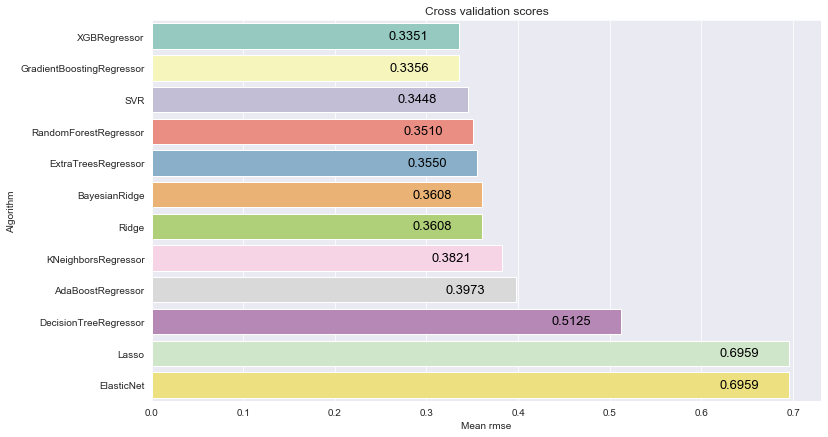

In [124]:
plt.figure(figsize=(12,7))
plot = sns.barplot("df_with_multicollinearity",'Algorithm',data = scores_df.sort_values(by='df_with_multicollinearity'), palette="Set3",orient = "h",)
for p in plot.patches:
        plot.annotate(s='{:.4f}'.format(p.get_width()),xy=(p.get_width(), p.get_y() + p.get_height()/2),
        ha='center', va='center', xytext=(-50, 0), textcoords='offset points', color='black',
        fontsize=13)
plot.set_xlabel("Mean rmse")
plot.set_title("Cross validation scores")

First of all, it should be noted that the lower the RMSE, the better the model. As we can see models with multicolarnity are more efficiency than models without multicolarnity. The best results were obtained by XGBRegressor - RMSE 0.351. In the next step for two best models we will try gain better performances by applying optimization of parameters

In [125]:
params = {
        'n_estimators': [500,1000, 1500],
        'max_depth': [5,10,15],
        'learning_rate' : [0.001, 0.01, 0.05]
        }

xgb = XGBRegressor()



gs = GridSearchCV(xgb, param_grid=params, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

xgb_reg=gs.best_estimator_

y_pred_xgb = xgb_reg.predict(X_test)
print(rmse(y_test,y_pred_xgb))

[15:39:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2861975496035365


In [126]:
gb_reg = GradientBoostingRegressor()
params = {
    'n_estimators': [500,1000, 1500],
    'max_depth': [5,10,15],
    'learning_rate' : [0.001, 0.01, 0.05],
    
         }

gs = GridSearchCV(gb_reg, param_grid=params, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

gb_reg=gs.best_estimator_

y_pred_gb = gb_reg.predict(X_test)
print(rmse(y_test,y_pred_gb))

0.28886294462200773


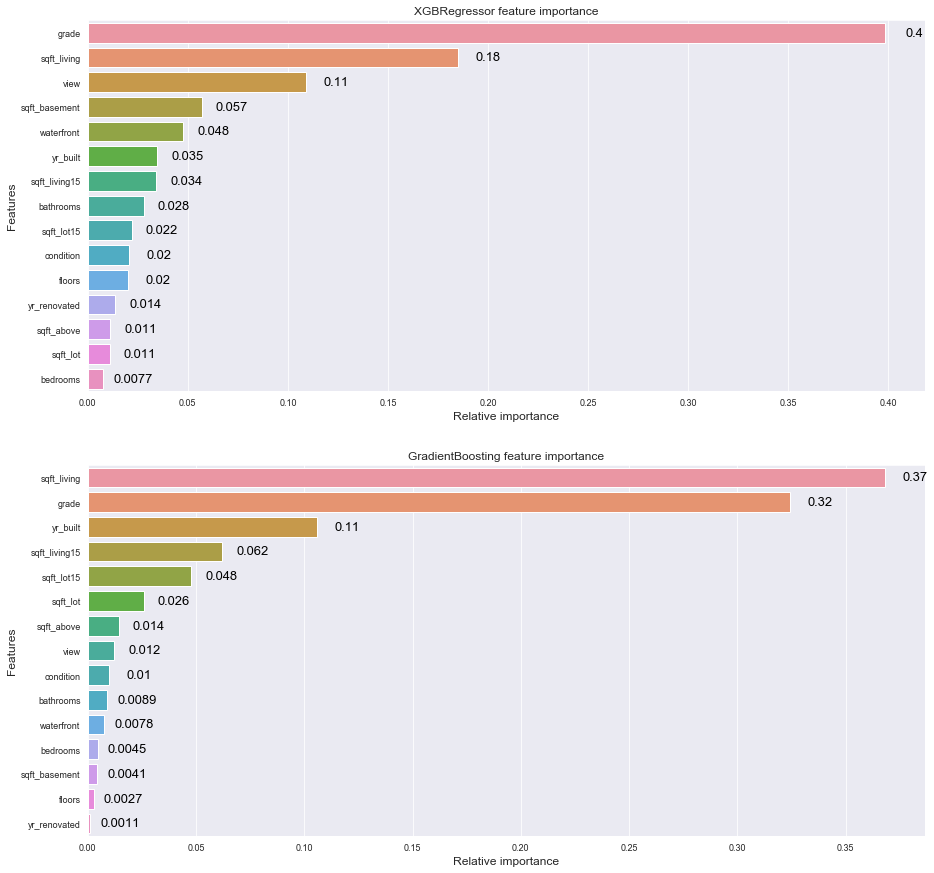

In [128]:
fig, axes = plt.subplots(nrows = 2, figsize=(15,15))

names_classifiers = [("XGBRegressor",xgb_reg),("GradientBoosting",gb_reg)]

nclassifier = 0
ncols = 2
for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    plot = sns.barplot(y=df.drop('log_price',axis=1).columns[indices],x = classifier.feature_importances_[indices] , orient='h',ax=axes[col])
    for p in plot.patches:
        plot.annotate(s='{:.2}'.format(p.get_width()),xy=(p.get_width(), p.get_y() + p.get_height()/2),
        ha='center', va='center', xytext=(30, 0), textcoords='offset points', color='black',fontsize=13)
    plot.set_xlabel("Relative importance",fontsize=12)
    plot.set_ylabel("Features",fontsize=12)
    plot.tick_params(labelsize=9)
    plot.set_title(name + " feature importance")
    nclassifier += 1


As suggested by the matrix correlation shown earlier, the most important for pricelevel of house are square footage of the house and overall grade given to the housing unit. Interestingly, variable yr_built, which had a very low level of price correlation, is ranked on third position for Gradient Boosting Regressor and sixth for XGBoost Regressor in terms of significance.

Below is a graph showing the errors of the prepared model.

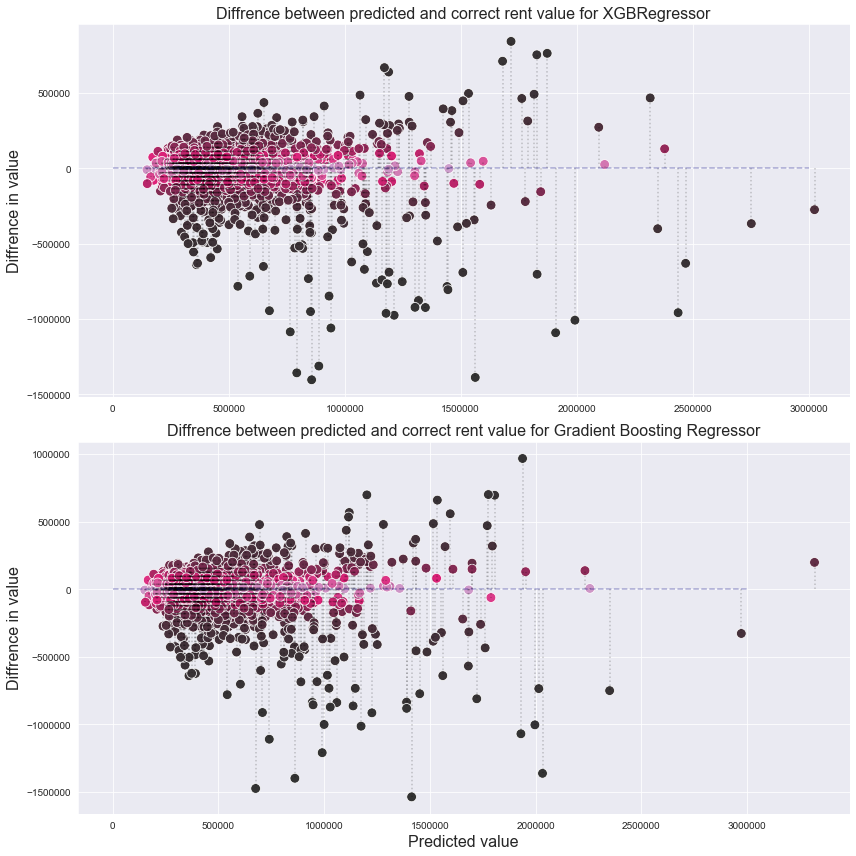

In [138]:
diffrence_etr = np.expm1(y_pred_xgb) - np.expm1(y_test)
diffrence_vr = np.expm1(y_pred_gb) - np.expm1(y_test)
colors = list(sns.color_palette("PuRd_d", len(diffrence_etr)))
colors.reverse()

plt.figure(figsize=(12,12))
plt.subplot(211)
sns.scatterplot(np.expm1(y_pred_xgb), diffrence_etr, hue=abs(diffrence_etr), palette=colors, s=95, legend=None)
plt.vlines(x=np.expm1(y_pred_xgb), ymin=0, ymax=diffrence_etr, alpha=.2, ls=':')
plt.hlines(y=0, xmin=0, xmax=3000000, ls='--', alpha=.3, color='navy')
plt.title('Diffrence between predicted and correct rent value for XGBRegressor', fontdict={'fontsize':16})
plt.ylabel('Diffrence in value', fontdict={'fontsize':16})
plt.xlabel('')

plt.subplot(212)
sns.scatterplot(np.expm1(y_pred_gb), diffrence_vr, hue=abs(diffrence_vr), palette=colors, s=95, legend=None)
plt.vlines(x=np.expm1(y_pred_gb), ymin=0, ymax=diffrence_vr, alpha=.2, ls=':')
plt.hlines(y=0, xmin=0, xmax=3000000, ls='--', alpha=.3, color='navy')

plt.title('Diffrence between predicted and correct rent value for Gradient Boosting Regressor', fontdict={'fontsize':16})
plt.ylabel('Diffrence in value', fontdict={'fontsize':16})
plt.xlabel('Predicted value', fontdict={'fontsize':16})
plt.tight_layout()
plt.show()

Lastly, a voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction. Model will be created that will contain  3 the best-performing models so far:XGBRegressor,Gradient Boosting Regressor, SVR. 

In [140]:
estimators = [
    ('xgbr', xgb_reg), 
    ('gbr', gb_reg),
    ('svr', SVR())]

In [141]:
vr = VotingRegressor(estimators=estimators)
vr.fit(X_train, y_train)
y_pred_vr = vr.predict(X_test)
print(rmse(y_test,y_pred_vr))

[16:56:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.28504537197946744


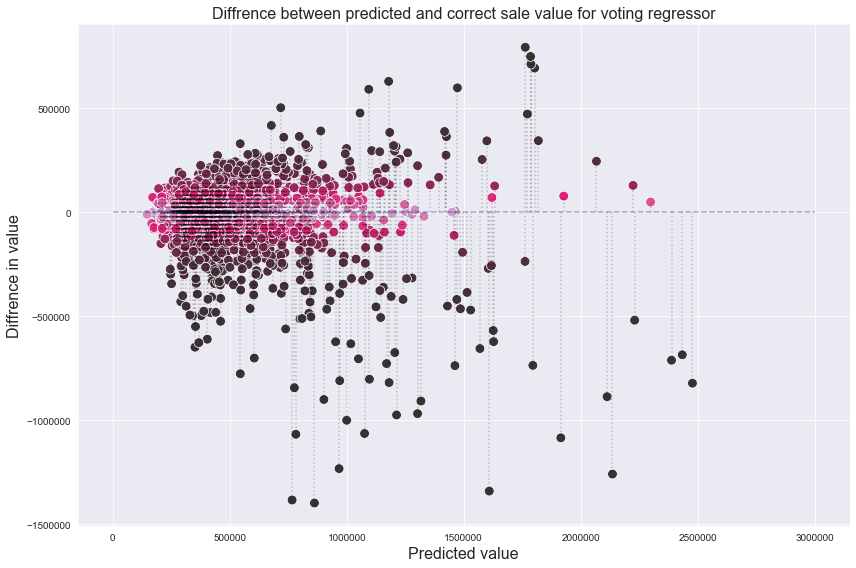

In [142]:

diffrence = np.expm1(y_pred_vr) - np.expm1(y_test)
colors = list(sns.color_palette("PuRd_d", len(diffrence)))
colors.reverse()

plt.figure(figsize=(12,8))
sns.scatterplot(np.expm1(y_pred_vr), diffrence, hue=abs(diffrence), palette=colors, s=95, legend=None)
plt.vlines(x=np.expm1(y_pred_vr), ymin=0, ymax=diffrence, alpha=.2, ls=':')
plt.hlines(y=0, xmin=0, xmax=3000000, ls='--', alpha=.3, color='navy')

plt.title('Diffrence between predicted and correct sale value for voting regressor', fontdict={'fontsize':16})
plt.ylabel('Diffrence in value', fontdict={'fontsize':16})
plt.xlabel('Predicted value', fontdict={'fontsize':16})
plt.tight_layout()
plt.show()

It should be noted that in the case of sales price prediction, the models make the biggest mistakes as the forecasted values increase. Excluding the largest errors that worsen the RMSE result achieved, the model is doing quite well - the vast majority of predictions are very close to true values.